In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm

## Simulating Game of Life, code from:  https://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/

### Time-step

In [2]:
def life_step(X):
    live_neighbors = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (live_neighbors == 3) | (X & (live_neighbors == 2)).astype(int)

In [3]:
import matplotlib.pyplot as plt

def generate_frames(num_frames, board_shape=(100,100), prob_alive=0.15):
    return np.array([
        np.random.choice([False, True], size=board_shape, p=[1-prob_alive, prob_alive])
        for _ in range(num_frames)
    ]).astype(int)

def render_frames(frame1, frame2, board_shape):
    plt.subplot(1, 2, 1)
    plt.imshow(frame1.flatten().reshape(board_shape), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(frame2.flatten().reshape(board_shape), cmap='gray')

In [4]:
def pad_input(X, board_shape=(20,20)):
    return np.array([
        np.pad(x.reshape(board_shape), (1,1), mode='wrap')
        for x in X
    ])

In [5]:
frames = generate_frames(10, board_shape=(100,100), prob_alive=0.15)

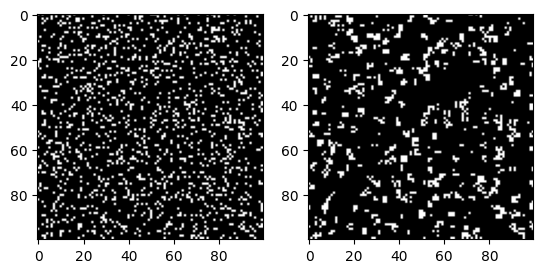

In [6]:
render_frames(frames[2],life_step(frames[2]),(100,100))

## Hyperparamters

In [149]:
l_r = 0.001
Device = 'cpu'
Batch_size = 100

In [167]:
CNNmodel = nn.Sequential(
    nn.Conv2d(1,100,3),
    nn.ReLU(),
    nn.Conv2d(100,1,1),
    nn.Sigmoid()
)

In [168]:
CNNmodel = CNNmodel.to(Device)

In [169]:
global_frames = generate_frames(10000, board_shape=(20,20), prob_alive=0.5)
global_frames_padded = pad_input(global_frames)

In [170]:
train_data = []
for i in range(len(global_frames)):
    train_data.append([torch.tensor(global_frames_padded[i].reshape((1,22,22)),dtype = torch.float32),torch.tensor(life_step(global_frames[i]).reshape((1,20,20)),dtype = torch.float32)])

In [171]:
trainloader = DataLoader(train_data, shuffle=False, batch_size=Batch_size)
i1, l1 = next(iter(trainloader))
print(l1.shape)

torch.Size([100, 1, 20, 20])


In [172]:
val_frames = generate_frames(2000, board_shape=(20,20), prob_alive=0.5)
val_frames_padded = pad_input(val_frames)

In [173]:
val_data = []
for i in range(len(val_frames)):
    val_data.append([torch.tensor(val_frames_padded[i].reshape((1,22,22)),dtype = torch.float32),torch.tensor(life_step(val_frames[i]).reshape((1,20,20)),dtype = torch.float32)])

In [174]:
val_loader = DataLoader(val_data, shuffle=False, batch_size=1000)

In [175]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(
        CNNmodel.parameters(), lr = l_r
    )

In [176]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave = True)
    mean_loss = []
    
    correct = 0
    numcounts = 0
    
    for batch_idx, (x,y) in enumerate(loop):
        x,y = x.to(Device), y.to(Device)
        out = model(x)
        loss = loss_fn(out,y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss= loss.item())
        correct += float(((out>0.5).float() == y).float().sum()/(Batch_size*20*20))
        numcounts += 1
    
    print("Accuracy was " + str(correct/numcounts))
    print("Mean loss was " + str(sum(mean_loss)/len(mean_loss)))

In [177]:
def val_accuracy(loader, model):
    correct = 0
    numcounts = 0
    i=0
    
    with torch.no_grad(): 
        for x,y in loader:
            x,y = x.to(Device), y.to(Device)
            out = model(x)
            correct += float(((out>0.5).float() == y).float().sum()/(1000*20*20))
            numcounts += 1
#             render_frames(y[0][0].cpu().detach().numpy().reshape(20,20),out[0][0].cpu().detach().numpy().reshape(20,20),(20,20))
    
    
    print("Val accuracy was " + str(correct/numcounts))
    
    if correct/numcounts==1.0:
        checkpoint = {
                "state_dict" : model.state_dict(),
                "optimizer" : optimizer.state_dict(),
            }
        torch.save(checkpoint, "overfit.pth.tar")
    
    return(correct/numcounts)

In [178]:
for epoch in range(15):
    print(epoch)
    train_fn(trainloader, CNNmodel, optimizer, loss_fn)
    a = val_accuracy(val_loader, CNNmodel)

0


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.05it/s, loss=0.491]


Accuracy was 0.6929682496190072
Mean loss was 0.5547576427459717
Val accuracy was 0.7104650139808655
1


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.17it/s, loss=0.411]


Accuracy was 0.7511227470636368
Mean loss was 0.4437252402305603
Val accuracy was 0.8028374910354614
2


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.91it/s, loss=0.356]


Accuracy was 0.8122825020551682
Mean loss was 0.3776720717549324
Val accuracy was 0.8074524998664856
3


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.10it/s, loss=0.299]


Accuracy was 0.8155307507514954
Mean loss was 0.3225672701001167
Val accuracy was 0.8464487493038177
4


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.19it/s, loss=0.247]


Accuracy was 0.8770147508382797
Mean loss was 0.26817980125546453
Val accuracy was 0.9071962535381317
5


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.91it/s, loss=0.202]


Accuracy was 0.9280597496032715
Mean loss was 0.2194758915901184
Val accuracy was 0.9381737411022186
6


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.65it/s, loss=0.169]


Accuracy was 0.949474248290062
Mean loss was 0.18190031811594964
Val accuracy was 0.9648800194263458
7


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.37it/s, loss=0.141]


Accuracy was 0.9741962480545044
Mean loss was 0.15195111244916915
Val accuracy was 0.978636234998703
8


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.52it/s, loss=0.116]


Accuracy was 0.9822832489013672
Mean loss was 0.12610523492097855
Val accuracy was 0.9845137596130371
9


100%|███████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.17it/s, loss=0.0963]


Accuracy was 0.9876087468862533
Mean loss was 0.10433044321835042
Val accuracy was 0.996194988489151
10


100%|███████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.11it/s, loss=0.0798]


Accuracy was 0.9971975010633468
Mean loss was 0.08631738513708115
Val accuracy was 0.9980949759483337
11


100%|███████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.27it/s, loss=0.0665]


Accuracy was 0.9996697503328323
Mean loss was 0.07177870206534863
Val accuracy was 1.0
12


100%|███████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.07it/s, loss=0.0557]


Accuracy was 1.0
Mean loss was 0.05993794180452824
Val accuracy was 1.0
13


100%|███████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.86it/s, loss=0.0466]


Accuracy was 1.0
Mean loss was 0.050187615193426606
Val accuracy was 1.0
14


100%|███████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.68it/s, loss=0.0393]


Accuracy was 1.0
Mean loss was 0.042214787490665914
Val accuracy was 1.0


In [146]:
dev_set = generate_frames(1, board_shape=(20,20), prob_alive=0.5)

In [147]:
x = torch.tensor(pad_input([dev_set[0]]).reshape((1,22,22)),dtype = torch.float32)
yhat = CNNmodel(x)
yhat = yhat.cpu().detach().numpy()
yhat = yhat.reshape(20,20)
yhat.shape

(20, 20)

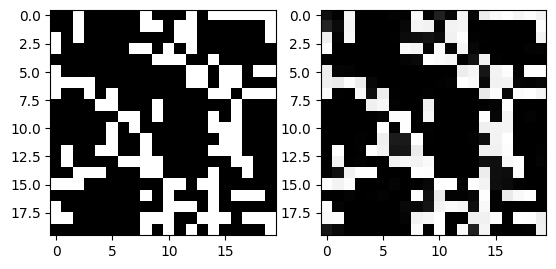

In [148]:
render_frames(life_step(dev_set[0]),yhat,(20,20))